In [1]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy
import pickle

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

from models import ConvNet, Net
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_noniid, CustomSubset, CustomDataset_mnist

torch.manual_seed(42)
np.random.seed(12)
tf.random.set_seed(123)

In [2]:
N_CLIENTS = 100
# DIRICHLET_ALPHA = 1.0


# data = datasets.EMNIST(root=".", split="byclass", download=True)

# mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
#       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
#       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
#       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
#       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

with open("../data/mnist/train_array_index.pkl", 'rb') as f:
    train_index = pickle.load(f)
with open("../data/mnist/test_array_index.pkl", 'rb') as f:
    test_index = pickle.load(f)

(train_x, train_labels), (test_x, test_labels) = mnist.load_data()
# train_dataset = CustomDataset_mnist(train_x, train_labels)
# test_dataset = CustomDataset_mnist(test_x, test_labels)

# idcs = np.random.permutation(len(data))
# train_idcs, test_idcs = idcs[:10000], idcs[10000:20000]
# train_labels = data.train_labels.numpy()

# client_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)

clients_trainset = [CustomDataset_mnist(train_x[idcs], train_labels[idcs],) for idcs in train_index]
clients_testset = [CustomDataset_mnist(test_x[idcs], test_labels[idcs]) for idcs in test_index]
# client_data = [CustomSubset(train_dataset, idcs) for idcs in client_idcs]
# test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))

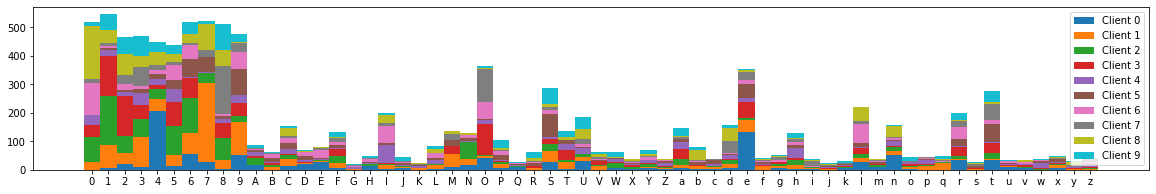

In [13]:
'''
plt.figure(figsize=(20,3))
plt.hist([train_labels[idc]for idc in client_idcs], stacked=True, 
         bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1),
        label=["Client {}".format(i) for i in range(N_CLIENTS)])
plt.xticks(np.arange(62), mapp)
plt.legend()
plt.show()
'''

Next, we simulate a clustering structure in the client population, by rotating the data for half of the first 5 clients by 180 degree. We display 10 data samples from the 1st and the 6th client for illustration.

In [4]:
for i, client_datum in enumerate(client_data):
    if i<5:
        client_datum.subset_transform = transforms.Compose([transforms.RandomRotation((180,180)),
                                                      transforms.ToTensor()])
    else:
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

In [3]:
clients_dataset = zip(clients_trainset, clients_testset)
clients = [Client(Net, lambda x : torch.optim.SGD(x, lr=0.01), data_train=train, data_test=test, idnum=i, batch_size=200) for i, (train, test) in enumerate(clients_dataset)]

server = Server(Net, train_x, test_x)

In [4]:
init_weight = np.load("init_weight.npy", allow_pickle=True)
from collections import OrderedDict
init_dict = OrderedDict()
for key, v in zip (server.model.state_dict().keys(), init_weight):
    init_dict[key] = torch.Tensor(v.T)
server.model.load_state_dict(init_dict)

<All keys matched successfully>

Client 0:


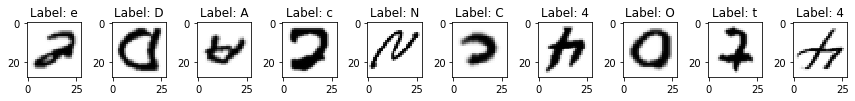

Client 5:


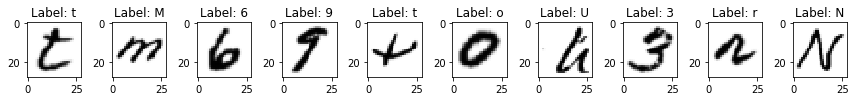

In [6]:
for client in [clients[0], clients[5]]:
    x, y = iter(client.train_loader).next()

    print("Client {}:".format(client.id))
    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i,0].numpy().T, cmap="Greys")
        plt.title("Label: {}".format(mapp[y[i].item()]))
    plt.show()

Now everything is set up to run our Clustered Federated Learning algorithm. During training, we will track the mean and std client accuracies, as well as the average and maximum client update norms.

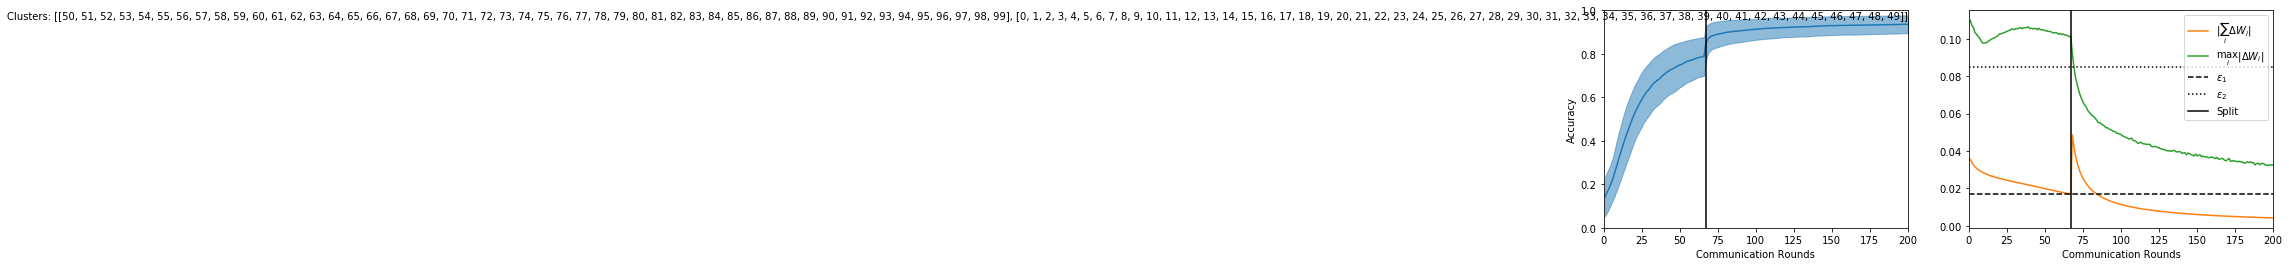

In [5]:
COMMUNICATION_ROUNDS = 200
EPS_1 = 0.017
EPS_2 = 0.085
    
    
cfl_stats = ExperimentLogger()
    
cluster_indices = [np.arange(len(clients)).astype("int")]
client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]


for c_round in range(1, COMMUNICATION_ROUNDS+1):

    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)
            
    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=1)
        client.reset()

    similarities = server.compute_pairwise_similarities(clients)

    cluster_indices_new = []
    for idc in cluster_indices:
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
             
        if mean_norm<EPS_1 and max_norm>EPS_2 and len(idc)>2 and c_round>20:
            
            server.cache_model(idc, clients[idc[0]].W, acc_clients)
            
            c1, c2 = server.cluster_clients(similarities[idc][:,idc]) 
            cluster_indices_new += [c1, c2]
             
            cfl_stats.log({"split" : c_round})

        else:
            cluster_indices_new += [idc]
        
        
    cluster_indices = cluster_indices_new
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

    server.aggregate_clusterwise(client_clusters)

    acc_clients = [client.test()[0] for client in clients]
    testloss_clients = [client.test()[1] for client in clients]
    
    cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                  "rounds" : c_round, "clusters" : cluster_indices,      "testloss_clients":testloss_clients})
    
    with open("../result/mnist_cfl_try1.txt", 'a+') as f:
        f.write("At round {:d}, test_loss is {:.4f}, accuracy is {:6f}, max_norm is {:.4f}, mean_norm is {:.4f}".format(c_round, np.mean(testloss_clients), np.mean(acc_clients), max_norm, mean_norm))
        f.write("\n")
    display_train_stats(cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS)

    
for idc in cluster_indices:    
    server.cache_model(idc, clients[idc[0]].W, acc_clients)

The training process resulted in multiple models for every client: A Federated Learning base model as well as more specialized models for the different clusters.  We can now compare their accuracies on the clients' validation sets, and assign each client the model which performed best.

In [10]:
results = np.zeros([10, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

In [11]:
frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) 
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9
FL Model,0.655340,0.692884,0.683333,0.675105,0.503759,0.600000,0.508671,0.683616,0.575472,0.638298
Model 0,0.757282,0.782772,0.787500,0.763713,0.654135,0.000000,0.000000,0.000000,0.000000,0.000000
Model 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.694118,0.595376,0.745763,0.740566,0.744681


As we can see, clustering improoved the accuracy for all clients by about 10%.